<a href="https://colab.research.google.com/github/JerushDan/Ds/blob/main/flight_delay_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix,classification_report,r2_score,roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler

In [ ]:
df=pd.read_csv('/content/Flight_delay.csv')
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Org_Airport,Dest,Dest_Airport,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,90,77,34,34,IND,Indianapolis International Airport,BWI,Baltimore-Washington International Airport,515,3.0,10.0,0.0,N,0.0,2.0,0.0,0.0,0.0,32.0
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,250,230,57,67,IND,Indianapolis International Airport,LAS,McCarran International Airport,1591,3.0,7.0,0.0,N,0.0,10.0,0.0,0.0,0.0,47.0
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,135,107,80,94,IND,Indianapolis International Airport,MCO,Orlando International Airport,828,6.0,8.0,0.0,N,0.0,8.0,0.0,0.0,0.0,72.0
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,240,213,15,27,IND,Indianapolis International Airport,PHX,Phoenix Sky Harbor International Airport,1489,7.0,8.0,0.0,N,0.0,3.0,0.0,0.0,0.0,12.0
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,135,110,16,28,IND,Indianapolis International Airport,TPA,Tampa International Airport,838,4.0,9.0,0.0,N,0.0,0.0,0.0,0.0,0.0,16.0


In [ ]:
df.columns.tolist()

['DayOfWeek',
 'Date',
 'DepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'Airline',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Org_Airport',
 'Dest',
 'Dest_Airport',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [ ]:
df=df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2.0
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10.0
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8.0
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3.0
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0.0
...,...,...,...,...,...,...,...
375268,5,16-05-2019,1019,Atlantic Southeast Airlines,DTW,ATL,39.0
375269,6,17-05-2019,1052,Atlantic Southeast Airlines,DTW,ATL,63.0
375270,4,22-05-2019,1004,Atlantic Southeast Airlines,DTW,ATL,0.0
375271,1,05-05-2019,1121,Atlantic Southeast Airlines,ATL,DTW,22.0


In [ ]:
df = df.dropna(subset=['CarrierDelay'])
df.isnull().sum()

,0
DayOfWeek,0
Date,0
DepTime,0
Airline,0
Origin,0
Dest,0
CarrierDelay,0


In [ ]:
#convert date columns to pandas datetime
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

In [ ]:
#month and day feature
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [ ]:
#drop the date column
df=df.drop(columns=['Date'])

In [ ]:
#identify categorical variables
categories=df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [ ]:
#dummy variables for categorical data
df_encoded=pd.get_dummies(df,drop_first=True)


In [ ]:
df_encoded['is_delayed_60+']=np.where(df_encoded['CarrierDelay']> 60,1,0)

In [ ]:
#defining train test split
X=df_encoded.drop(columns=['CarrierDelay','is_delayed_60+'])
y=df_encoded['is_delayed_60+']

In [ ]:
#train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
#eda
train_set=pd.concat([X_train,y_train],axis=1)

In [ ]:
for category in categories:
    one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]

    if one_hot_columns:  # Proceed only if the list is not empty
        train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
        train_set = train_set.drop(columns=one_hot_columns)
        train_set[category] = train_set[category].str.replace(f'{category}_', '')


In [ ]:
train_set

,DayOfWeek,DepTime,month,day,is_delayed_60+,Airline,Origin,Dest
64300,2,932,1,22,0,American Eagle Airlines Inc.,FWA,ORD
302037,4,1738,4,17,0,Delta Air Lines Inc.,ATL,TPA
362231,4,1535,5,1,0,United Air Lines Inc.,ORD,SNA
283619,6,1018,4,19,0,Skywest Airlines Inc.,TUS,DEN
160648,5,1901,2,8,0,American Airlines Inc.,DFW,LGA
...,...,...,...,...,...,...,...,...
259178,7,1918,3,9,0,American Airlines Inc.,SEA,KTN
365838,4,1510,5,1,0,United Air Lines Inc.,DEN,LAS
131932,3,950,2,20,0,US Airways Inc.,SAN,PHX
146867,4,1236,2,21,0,American Eagle Airlines Inc.,MOB,DFW


In [ ]:
train_set['is_delayed_60+'].value_counts()

,count
is_delayed_60+,
0,242886
1,19804


In [ ]:
train_set['is_delayed_60+'].mean()

np.float64(0.07538924207240473)

In [ ]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)+100

,is_delayed_60+
Airline,
Atlantic Southeast Airlines,100.165
Hawaiian Airlines Inc.,100.148
Skywest Airlines Inc.,100.105
American Airlines Inc.,100.090
Delta Air Lines Inc.,100.086
United Air Lines Inc.,100.077
US Airways Inc.,100.075
American Eagle Airlines Inc.,100.074
Frontier Airlines Inc.,100.057


In [ ]:
DayOfWeek_delay=train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)+100
DayOfWeek_delay

,is_delayed_60+
DayOfWeek,
6,100.093
3,100.081
7,100.079
1,100.074
2,100.073
4,100.070
5,100.066


In [ ]:
#delays at airport
pct_delaybyorigin=train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delaybyorigin.head(20)


,is_delayed_60+
Origin,
MQT,37.5
ACY,37.5
MEI,33.3
HHH,27.1
AVP,26.5
FAY,25.3
PHF,24.7
OAJ,24.4
TRI,23.8


Text(0, 0.5, 'Frequency')

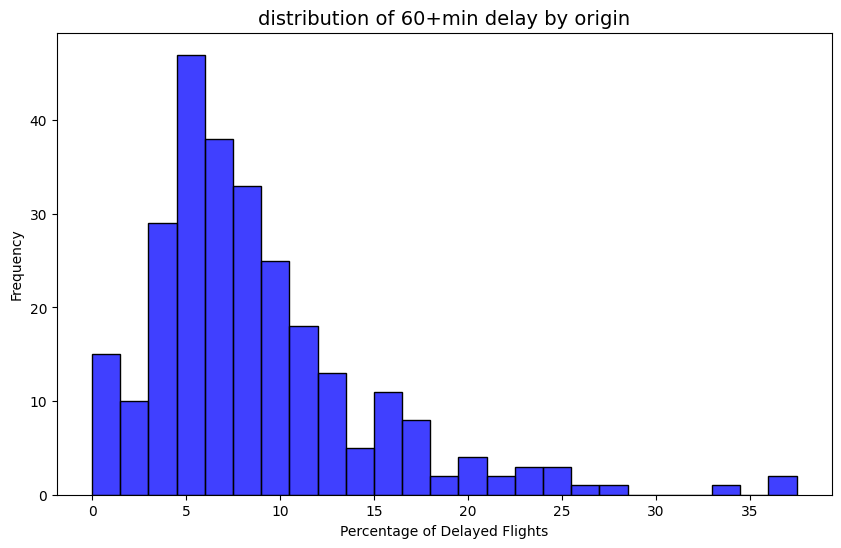

In [ ]:
#histogram
plt.figure(figsize=(10,6))
sns.histplot(pct_delaybyorigin.values,bins=25,color='blue',edgecolor='black')
plt.title('distribution of 60+min delay by origin',fontsize=14)
plt.xlabel('Percentage of Delayed Flights')
plt.ylabel('Frequency')

In [ ]:
#xgboost
xgb_model=xgb.XGBClassifier(random_state=42,eval_metric='logloss')
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred=xgb_model.predict(X_test)

In [ ]:
print('accuarcy :' ,accuracy_score(y_test,y_pred))

accuarcy : 0.9258229557122808


In [ ]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[104161,     42],
       [  8309,     70]])